In [3]:
using PyPlot
using JLD
using Dates
using Statistics: mean, var

mr  = include("../../Tools/Model_Reduction_Dev.jl")
at  = include("../../Tools/AnalysisToolbox.jl")
kmr = include("KSE_modredTools.jl")

Unable to init server: Could not connect: Connection refused
Unable to init server: Could not connect: Connection refused

(.:13286): Gdk-CRITICAL **: 14:53:12.684: gdk_cursor_new_for_display: assertion 'GDK_IS_DISPLAY (display)' failed

(.:13286): Gdk-CRITICAL **: 14:53:12.688: gdk_cursor_new_for_display: assertion 'GDK_IS_DISPLAY (display)' failed


Main.KSE_modredTools

In [4]:
server = startswith(pwd(), "/u5/jaredm") ? true : false
# When I want the standard lin et al. (2017) data.
sol_file = server ? "../../../data/KSE_Data/KSE_sol_linn.jld" :
   "Data/KSE_sol_linn.jld"

"../../../data/KSE_Data/KSE_sol_linn.jld"

In [5]:
# Load Old Data
@time Data = load(sol_file)
print("Data Loaded")
uu      = Data["dat_uu"];  
vv      = Data["dat_vv"];
tt      = Data["dat_tt"];
obs_gap = Data["obs_gap"];
h       = Data["h"];

P       = Data["P"]
N       = Data["N"]

Δt = h*obs_gap

  2.475144 seconds (4.45 M allocations: 1.297 GiB, 3.03% gc time)
Data Loaded

0.1

## View data

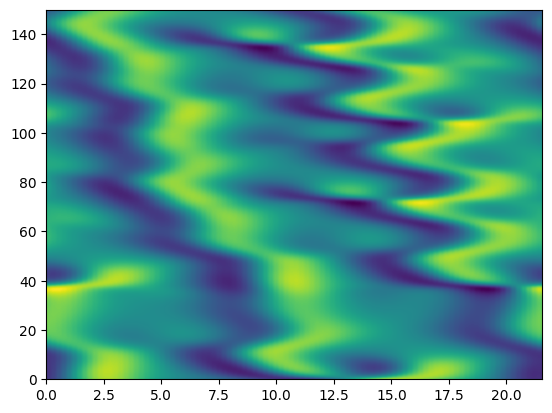

PyObject <matplotlib.image.AxesImage object at 0x7f6e9834fee0>

In [6]:
t_start = 0
t_stop = 150
ind_start = floor(Int,t_start/Δt)+1
ind_stop =floor(Int,t_stop/Δt)

H1 = imshow(uu[:,ind_start:ind_stop]', extent=[0,21.55,0,150], aspect="auto")

## Get tools (Psi, sig, pred)

In [9]:
Psi(x) = kmr.PSI(x; h, obs_gap, P, N)


Psi (generic function with 1 method)

In [10]:
sig = vv[2:6,2:end]

5×500000 Array{Complex{Float64},2}:
   0.319701+0.0460596im   0.326616+0.054231im   …   0.270115-0.523138im
  -0.951524+0.871918im   -0.958125+0.866855im       0.272794+0.115175im
    1.65154+1.24755im      1.66558+1.28775im       -0.321451+0.00567049im
  -0.866203+0.0937057im  -0.851714+0.0889444im      0.902827-0.88528im
 -0.0173149+0.129443im   -0.022104+0.140815im       0.181263-0.352839im

In [11]:
pred = mr.get_pred(vv[2:6,1:end-1], Psi)

25×500000 Array{Complex{Float64},2}:
    0.312519+0.0376706im    …     0.273726-0.517633im
   -0.944952+0.876568im           0.261911+0.0851941im
     1.63705+1.20801im           -0.270844+0.0398932im
   -0.880294+0.0985232im          0.865414-0.908783im
  -0.0130653+0.118098im            0.19463-0.356906im
    0.312171+0.038293im     …     0.273809-0.517688im
   -0.944212+0.875567im           0.261611+0.0852601im
     1.63723+1.20845im           -0.270865+0.0391246im
   -0.880719+0.0978813im          0.865628-0.909044im
  -0.0126246+0.122476im           0.193553-0.356438im
   -0.288186-0.306651im     …     0.294231-0.185476im
     1.75787-2.59842im             1.02549-0.318059im
    -7.01773+1.63445im           -0.218976-0.0831367im
   -0.189964-4.56097im            0.160142+0.172862im
   -0.819825+0.755502im           0.420344-0.272569im
    0.363235+0.285288im     …     -0.16266+0.100002im
    -1.47952+3.10922im           -0.564896+0.168275im
     7.34599-2.9296im             0.1196

In [12]:
pred_m = mean(pred,dims=2)

25×1 Array{Complex{Float64},2}:
  0.0050487298284785246 - 0.008310535033210146im
   -0.03072685418961435 + 0.006909737557162396im
   0.002668248519736691 - 0.005651087685252557im
     8.2631295695111e-5 + 0.009135312422185165im
  -0.004065936662958523 - 0.0012572931153842033im
   0.005052415949540015 - 0.008315106091187146im
     -0.030723471412524 + 0.006914859883168329im
   0.002666355471950482 - 0.005643539733350083im
 0.00010026671587611279 + 0.009168391493356864im
  -0.004065823418942502 - 0.0012597295133176022im
  -0.005867643081889904 - 4.9024857441650715e-6im
   0.014232062375551769 - 0.029561135518681544im
    0.06093158914821774 - 0.002365506273366546im
    0.06695010776481444 + 0.06038052593540107im
   -0.00219013037131941 - 0.009174950669308428im
   0.009332731502370819 - 0.004908738162128955im
  -0.032131536243379985 - 0.017914764541375507im
   0.004980269124732864 + 0.008840095318271624im
   -0.02281282682288451 - 0.010357223207951058im
    0.00407517962169106 + 0.0017511

## Autocovariances

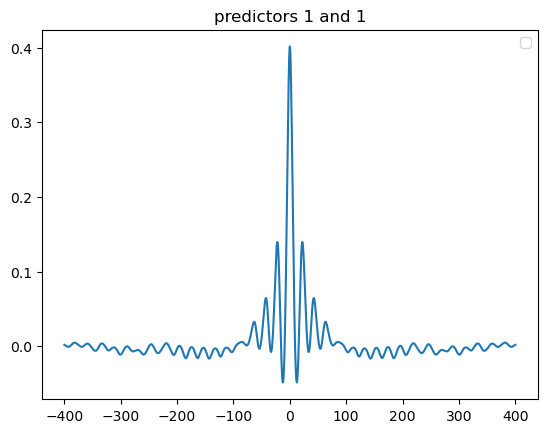

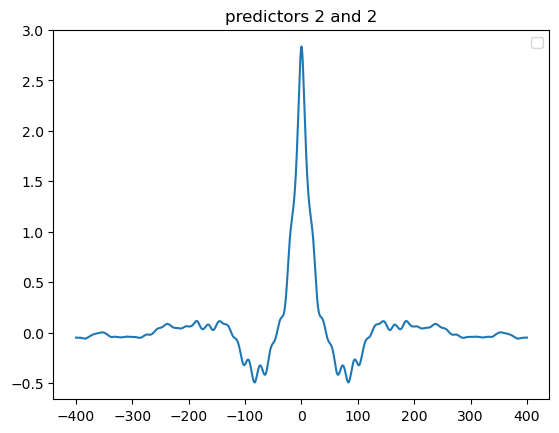

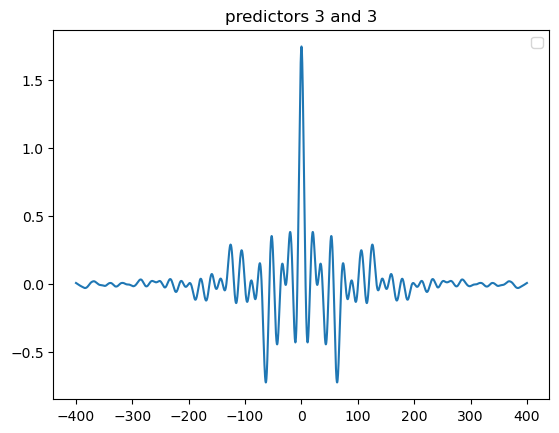

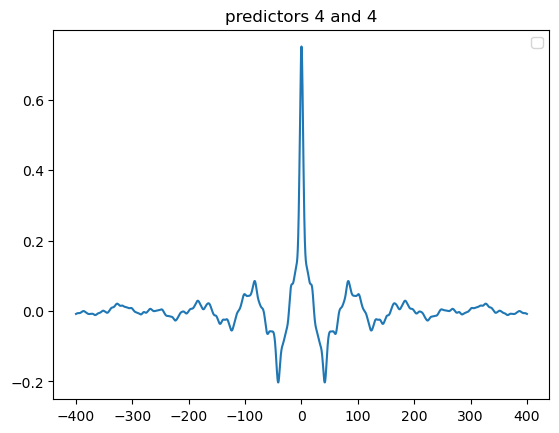

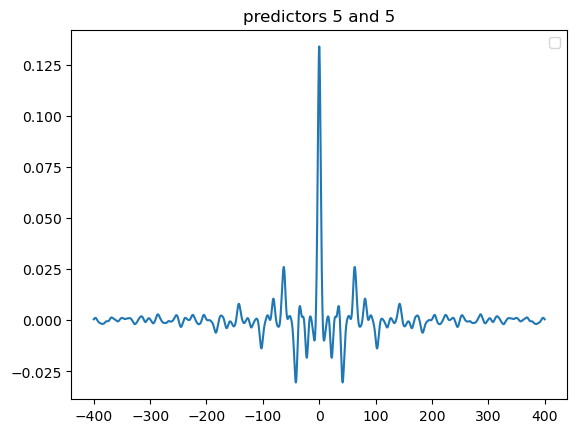

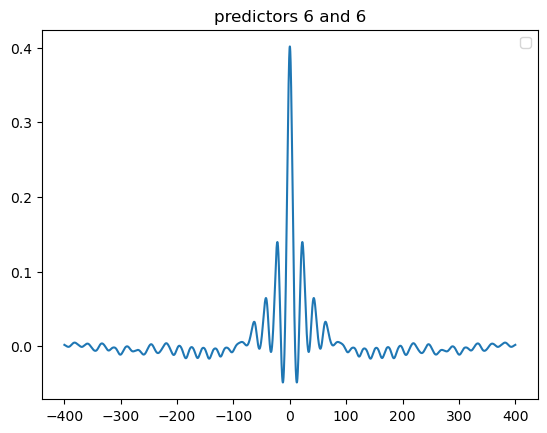

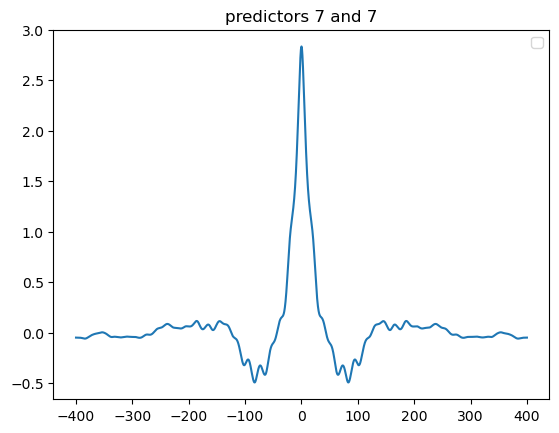

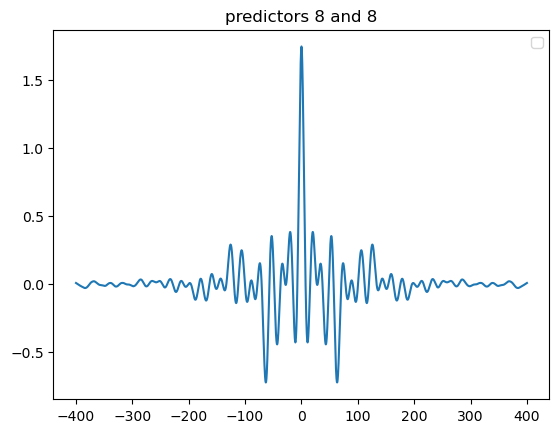

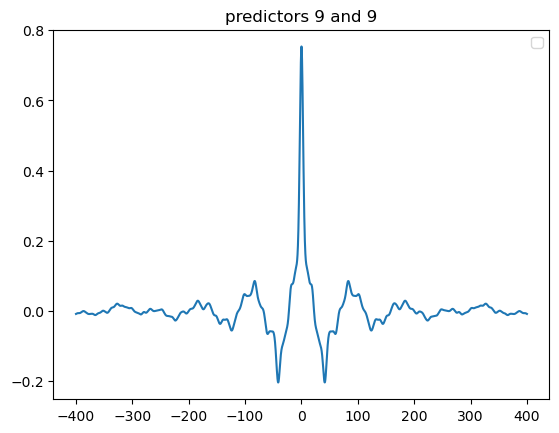

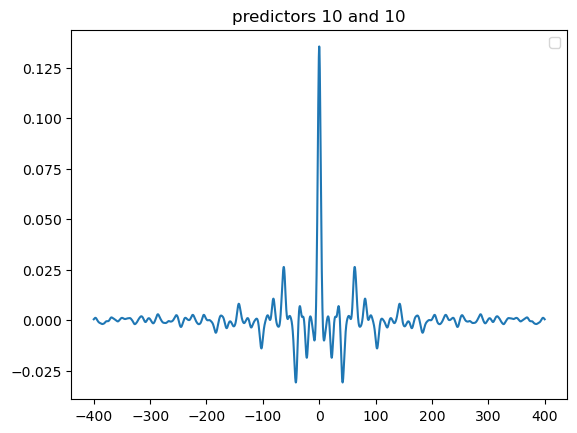

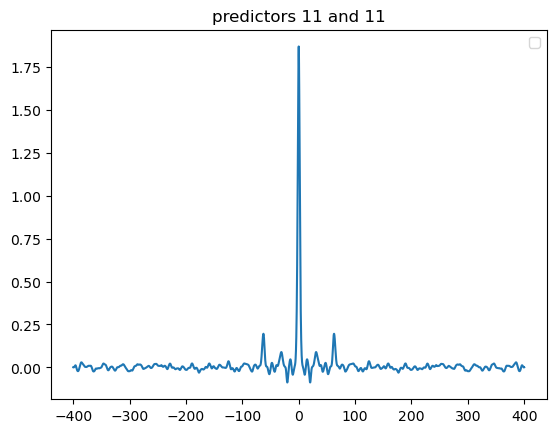

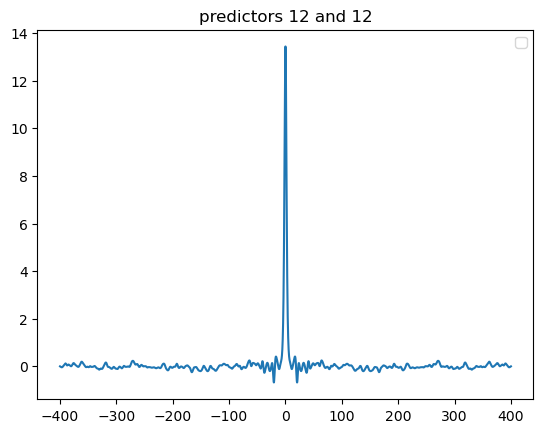

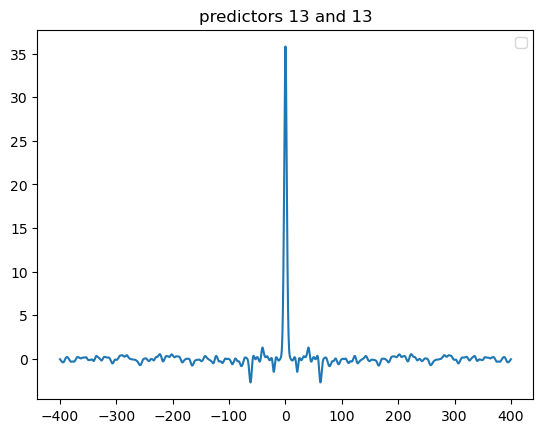

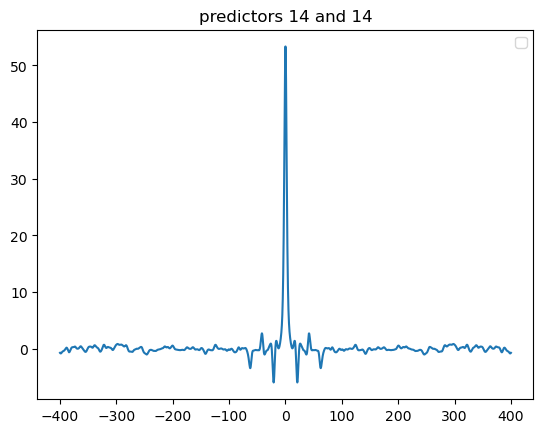

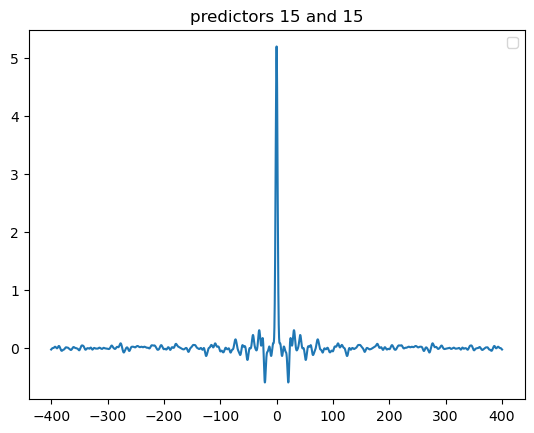

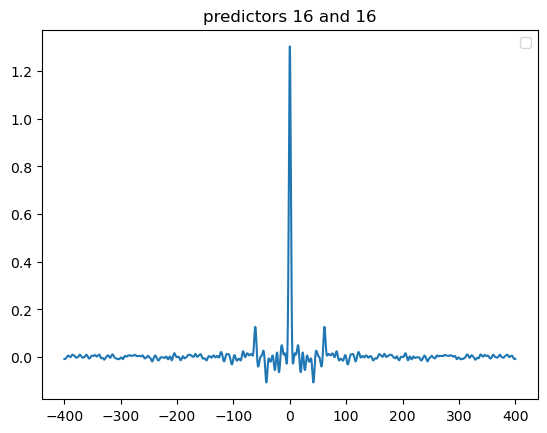

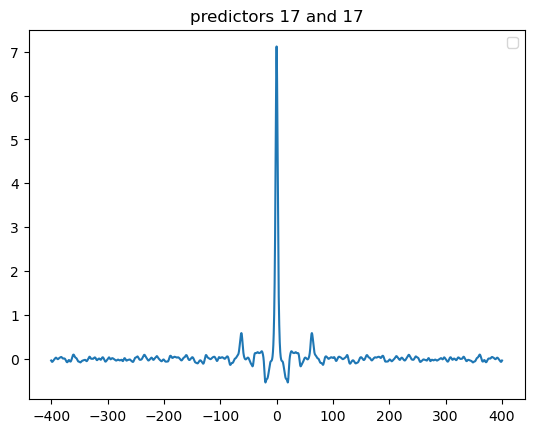

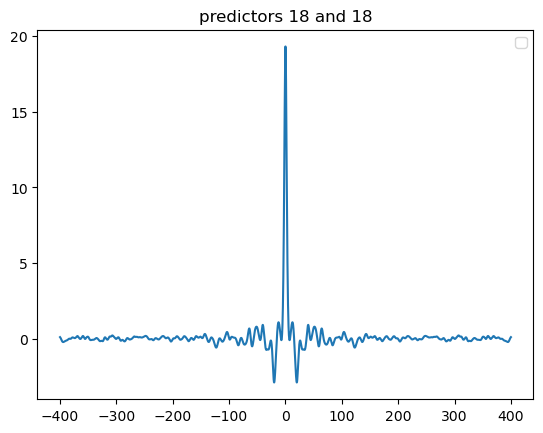

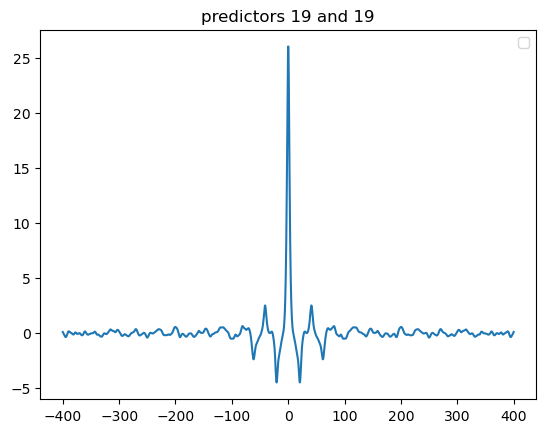

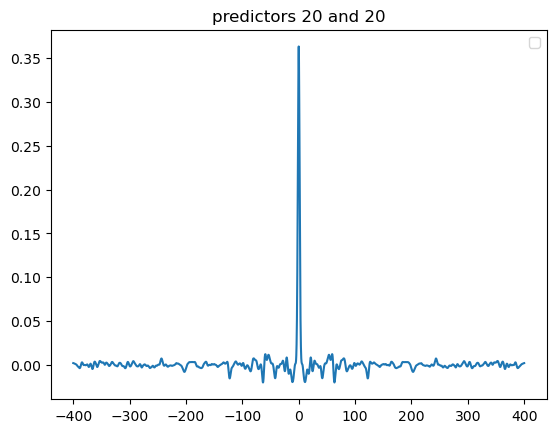

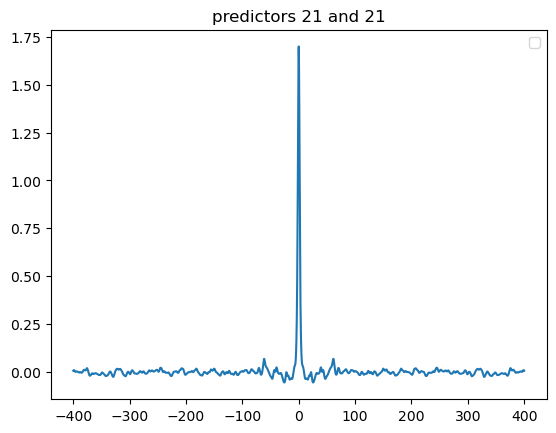

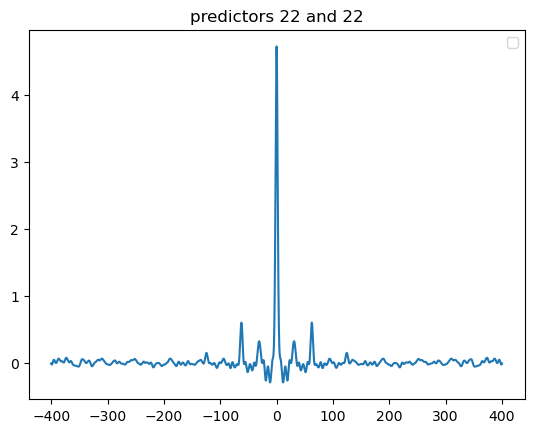

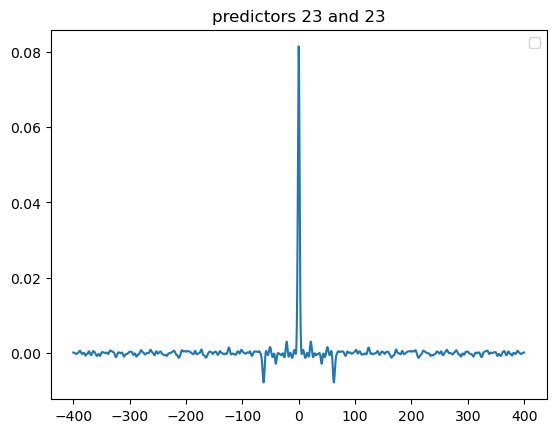

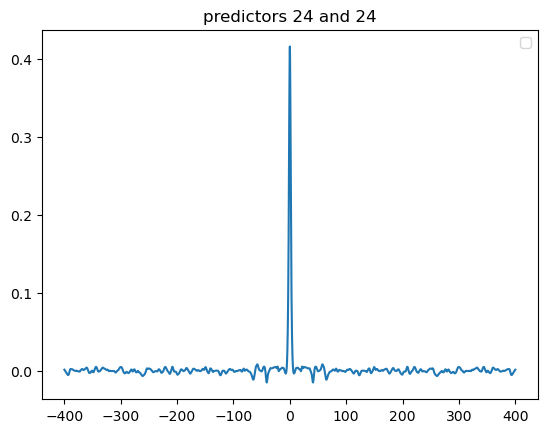

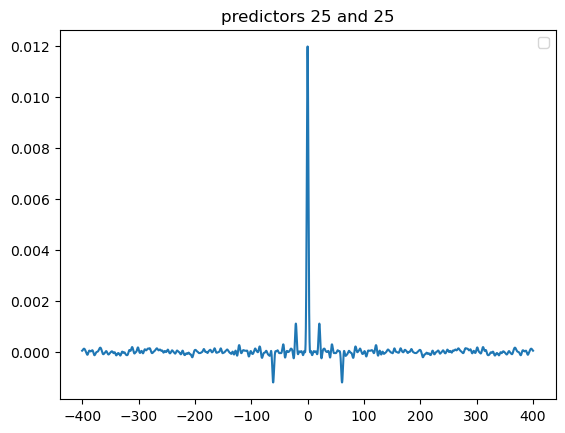

C:\Users\jared\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.
C:\Users\jared\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.
C:\Users\jared\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.
C:\Users\jared\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.
C:\Users\jar

In [12]:
lags = -4000:4000
let plt = plot
    for m = 1:25
        figure()
        A = at.my_crosscov(pred[m,:],pred[m,:],lags)
        plt(Δt*lags,A)
        legend()
        title("predictors $m and $m")
    end
end

## Cross Covariances

In [ ]:
n = 5
lags = -10000:10000
let plt = plot
    for m = 1:25
        figure()
        A = at.my_crosscov(sig[n,:],pred[m,:],lags)
        plt(Δt*lags,A)
        legend()
        title("modes $n and $m")
    end
end

## Power Spectra and Cross Power Spectra 

In [40]:
L = 1000
Nex = 2^12

4096

In [ ]:
z_crossspect_sigpred_num_fft = at.z_crossspect_fft_old(sig, pred; L, Nex);

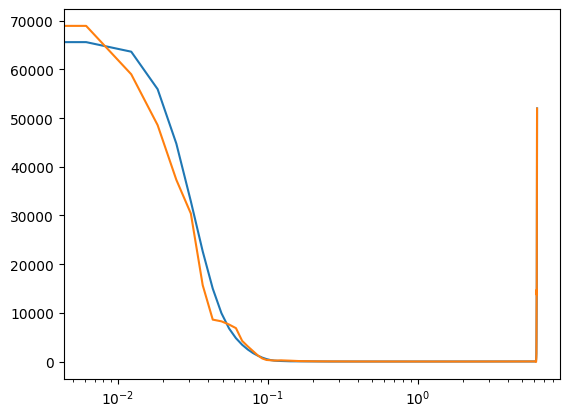

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7f8685f100>

In [30]:
L = 200
Nex = 2^10
n = 2
p = 5
nfft = Nex

Theta = 2π/Nex*(0:Nex-1)
points =  Nex

n = 2
m = 2
S_sigpred_dm = at.z_crossspect_dm(sig[n,:],pred[m,:]; L, Nex)
S_sigpred_sp = at.z_crossspect_scalar_ASP(sig[n,:],pred[m,:]; n,p, nfft )

semilogx(Theta[1:end÷points:end],S_sigpred_dm[1:end÷points:end])
semilogx(Theta[1:end÷points:end],S_sigpred_sp[1:end÷points:end])

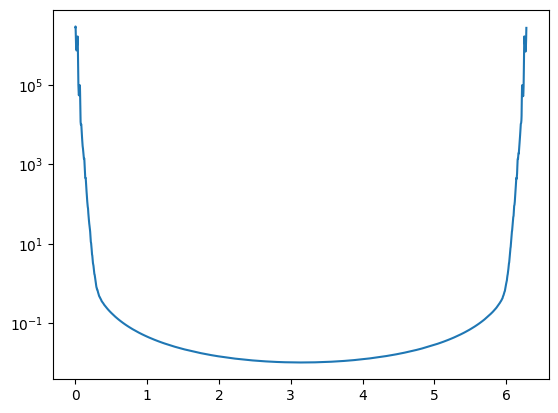

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff725741a30>

In [69]:
n = 1
m = 6
semilogx(Theta[1:end ÷ points:end],z_crossspect_sigpred_num_fft[n,m,1:end÷points:end])

In [ ]:
S_sigpred = z_crossspect_dm(sig[n,:],pred; L, Nex)
semilogy(Theta[1:end ÷ points:end],z_crossspect_sigpred_num_fft[n,m,1:end÷points:end])